In [1]:
import os, glob, sys, io
import pathlib

from pprint import pprint
import numpy as np
import random
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import scipy
import scipy.signal
import scipy.interpolate

import pickle
from tqdm.auto import tqdm, trange


from IPython.core.display import display, HTML

In [24]:
out_dir = "F:/MohammadRaziei/project/Dataset/ismrmrd_to_npz"
# out_dir = "H:/Dataset/Bio/MRI Reconstruction/ismrmrd_to_npz"
pickle_dir = "F:/MohammadRaziei/project/Dataset/npz_to_pickle"
# pickle_dir = "H:/Dataset/Bio/MRI Reconstruction/npz_to_pickle"
pickle_batch_root = "F:/MohammadRaziei/project/Dataset/pickle_batch_root"

filenames = glob.glob(out_dir+"/*.npz")
len(filenames)

50

In [3]:
fid = 25;
uuid = pathlib.Path(filenames[fid]).stem
source = np.load(filenames[fid], allow_pickle=True)
kspace = source['kspace']
info = source['info'].item()
lNx,lNy,lNz = info['lNx'],info['lNy'],info['lNz']
kspace.shape

(1, 1, 40, 15, 1, 517, 320)

In [4]:
pd.DataFrame.from_dict(info, orient='index').T

,lNx,lNy,lNz,eNx,eNy,eNz,rNx,rNy,rNz,eFOVx,eFOVy,eFOVz,rFOVx,rFOVy,rFOVz,ncoils,nslices,nreps,ncontrasts
0,320.0,517.0,1.0,640.0,646.0,1.0,320.0,320.0,1.0,280.0,282.799988,4.5,140.0,140.0,3.0,15.0,40.0,1.0,1.0


In [5]:
all_info = [np.load(fname, allow_pickle=True)['info'].item() for fname in filenames]
pd_info = pd.DataFrame(all_info)
pd_info

,lNx,lNy,lNz,eNx,eNy,eNz,rNx,rNy,rNz,eFOVx,eFOVy,eFOVz,rFOVx,rFOVy,rFOVz,ncoils,nslices,nreps,ncontrasts
0,320,387,1,640,484,1,320,320,1,280.0,211.679993,4.5,140.0,140.0,3.0,15,37,1,1
1,384,616,1,768,770,1,384,384,1,280.0,280.700012,4.5,140.0,140.0,3.0,15,31,1,1
2,320,387,1,640,484,1,320,320,1,280.0,211.679993,4.5,140.0,140.0,3.0,15,38,1,1
3,320,517,1,640,646,1,320,320,1,280.0,282.799988,4.5,140.0,140.0,3.0,15,33,1,1
4,320,387,1,640,484,1,320,320,1,280.0,211.679993,4.5,140.0,140.0,3.0,15,40,1,1
5,320,387,1,640,484,1,320,320,1,280.0,211.679993,4.5,140.0,140.0,3.0,15,38,1,1
6,320,387,1,640,484,1,320,320,1,280.0,211.679993,4.5,140.0,140.0,3.0,15,38,1,1
7,320,387,1,640,484,1,320,320,1,280.0,211.679993,4.5,140.0,140.0,3.0,15,36,1,1
8,384,616,1,768,770,1,384,384,1,280.0,280.700012,4.5,140.0,140.0,3.0,15,34,1,1
9,320,387,1,640,484,1,320,320,1,280.0,211.679993,4.5,140.0,140.0,3.0,15,39,1,1


In [6]:
mNx, mNy = pd_info['lNx'].max(), pd_info['lNy'].max()
mNx, mNy

(384, 616)

In [7]:
pd_info['nslices'].sum()

1740

In [8]:
data_orig = np.squeeze(kspace)
data_orig.shape

(40, 15, 517, 320)

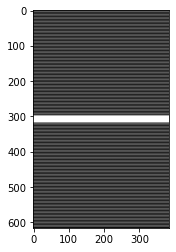

In [10]:
mask_k = np.zeros((mNy, mNx))
mask_k[::4,:] = 1

w = 10;
mask_w = np.zeros((mNy, mNx))
mask_w[mNy//2-w:mNy//2+w,:] = 1

mask_t = np.logical_or(mask_k, mask_w)

plt.imshow(mask_t, cmap='gray')#,interpolation='none')
plt.show()

In [9]:
s = data_orig.shape
padding = [mNy-s[-2], mNx-s[-1]]
# data = tf.pad(data_orig, [[0,0], [0,0], [1, 1], [2, 2]], "CONSTANT")  
data = np.pad(data_orig, [[0,0], [0,0], [int(np.floor(padding[0]/2)), int(np.ceil(padding[0]/2))], 
                          [int(np.floor(padding[1]/2)), int(np.ceil(padding[1]/2))]],  "constant")
data.shape

(40, 15, 616, 384)

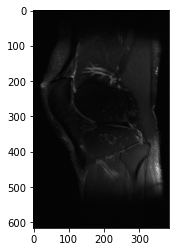

Wall time: 3.01 s


In [11]:
%%time
im = np.fft.fftshift(scipy.fft.fft2(data, workers=os.cpu_count()))
im = np.sqrt(np.sum(im**2,1))
plt.imshow(np.abs(im[5]), cmap='gray')
plt.show()

In [12]:
%timeit scipy.fft.fft2(data, workers=os.cpu_count())

1.18 s ± 37.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
# import cupy as cp
# import cupyx.scipy.fft as cufft
# import scipy.fft
# # scipy.fft.set_global_backend(cufft)
# import cupyx.scipy.fft


In [13]:
class MultiSliceKSpaceGenerator(tf.keras.utils.Sequence):
    def __init__(self,npz_dir, maxSize):
        self.filenames = glob.glob(npz_dir+"/*.npz")
        self.maxSize = maxSize
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, index):
        return self.getitem(index)
    def getitem(self, index):
        return self.get_padded_kspace(index)
    
    def get_padded_kspace(self, index):
        source = np.load(filenames[index], allow_pickle=True)
        kspace = source['kspace']
        data_orig = np.squeeze(kspace)
        s = data_orig.shape
        info = source['info'].item()
        lNx,lNy = info['lNx'],info['lNy']
        padding = [self.maxSize[1]-lNy, self.maxSize[0]-lNx]
        data = np.pad(data_orig, [[0,0], [0,0], [int(np.floor(padding[0]/2)), int(np.ceil(padding[0]/2))], 
                          [int(np.floor(padding[1]/2)), int(np.ceil(padding[1]/2))]],  "constant")
        return data
    
    def get_uuid(self, index):
        return pathlib.Path(self.filenames[index]).stem
    
    @staticmethod
    def transform_to_images_coils(data):
        return np.fft.fftshift(scipy.fft.fft2(data, workers=os.cpu_count()))
    @staticmethod
    def combine_coil_images(im):
        return np.sqrt(np.sum(im**2,1))
    @staticmethod
    def transform_to_images(data):
        return MultiSliceKSpaceGenerator.combine_coil_images(
            MultiSliceKSpaceGenerator.transform_to_images_coils(data))




Wall time: 6.19 s
Wall time: 2.13 s


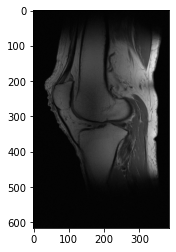

In [14]:
kspacegen = MultiSliceKSpaceGenerator(out_dir, [mNx, mNy])
%time X = kspacegen[10]
%time images = kspacegen.transform_to_images(X)
plt.imshow(np.abs(images[5]), cmap='gray');plt.show()

In [16]:
pathlib.Path(pickle_dir).mkdir(parents=True, exist_ok=True)

number_of_data = len(kspacegen)
for i in trange(number_of_data):
    uuid = kspacegen.get_uuid(i)
    all_data = kspacegen[i]
    for j in trange(all_data.shape[0], leave=False):
        data = all_data[j]
        with open(os.path.join(pickle_dir, "%s--%02.0f.pickle"%(uuid,j)), "wb") as f:
                    pickle.dump(data, f)
   

In [19]:
class BatchKSpaceGenerator(tf.keras.utils.Sequence):
    def __init__(self, pickle_dir, batchSize, shuffle=True):
        self.filenames = glob.glob(pickle_dir+"/*.pickle")
        self.batch_size = batchSize
        self.length = int(np.ceil(len(self.filenames)/batchSize))
        length = self.length * batchSize
        
        self.shuffle = shuffle
        self.indices_ref = range(len(self.filenames))
        self.indices_ref =np.concatenate([self.indices_ref, 
                                          random.sample(self.indices_ref, length-len(self.indices_ref))])

        self.on_epoch_end()

    def on_epoch_end(self):
        self.indices = self.indices_ref.copy()
        if self.shuffle:
            np.random.shuffle(self.indices)

        
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        return self.getitem(index)
    def getitem(self, ind):
        index = ind*self.batch_size;
        indices = self.indices[index:index+self.batch_size]
        data =[]
        for idx in tqdm(indices, leave=False):
            filename = self.filenames[idx]
            with open(filename, 'rb') as f:
                data.append(pickle.load(f))
        return np.array(data)
    
#     def get_uuid(self, index):
#         return pathlib.Path(self.filenames[index]).stem
    
    @staticmethod
    def read_pickle(filename):
        with open(filename, 'rb') as f:
            X = pickle.load(f)
        return X
        
    @staticmethod
    def transform_to_images_coils(data):
        return np.fft.fftshift(scipy.fft.fft2(data, workers=os.cpu_count()))
    @staticmethod
    def combine_coil_images(im):
        return np.sqrt(np.sum(im**2,1))
    @staticmethod
    def transform_to_images(data):
        return MultiSliceKSpaceGenerator.combine_coil_images(
            MultiSliceKSpaceGenerator.transform_to_images_coils(data))




In [16]:
batch_size = 128

In [20]:
kspacegen = BatchKSpaceGenerator(pickle_dir, batch_size, shuffle=True)
len(kspacegen)

14

In [23]:
%%time
kspacegen[1].shape

  0%|          | 0/128 [00:00<?, ?it/s]

Wall time: 32.1 s


(128, 15, 616, 384)

In [25]:
data_root = os.path.join(pickle_batch_root, str(batch_size))
pathlib.Path(data_root).mkdir(parents=True, exist_ok=True)


In [27]:
number_batch = len(kspacegen)
for i in trange(number_batch):
    data = kspacegen[i]
    with open(os.path.join(data_root, "%04.0f.pickle"%(i)), "wb") as f:
        pickle.dump(data, f)

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

In [34]:
class KSpaceGenerator(tf.keras.utils.Sequence):
    def __init__(self, pickle_root_dir, mask):
        self.filenames = glob.glob(pickle_root_dir+"/*.pickle")
        self.mask = mask
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, index):
        return self.getitem(index)
        
    def getitem(self, index):
        with open(self.filenames[i], 'rb') as f:
            padded = pickle.load(f)
        inp = padded*self.mask
        out1 = padded
        return inp, out1

    
    @staticmethod
    def transform_to_image_coils(data):
        return np.fft.fftshift(scipy.fft.fft2(data, workers=os.cpu_count()))
    @staticmethod
    def combine_coil_images(im):
        return np.sqrt(np.sum(im**2,1))
    @staticmethod
    def transform_to_images(data):
        return KSpaceGenerator.combine_coil_images(KSpaceGenerator.transform_to_image_coils(data))
   


In [35]:
kspacegen = KSpaceGenerator(data_root, mask_t)
len(kspacegen)

14

In [42]:
%time X,Y = kspacegen[0] 

Wall time: 3.52 s


Wall time: 8.1 s


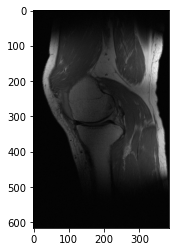

Wall time: 8.35 s


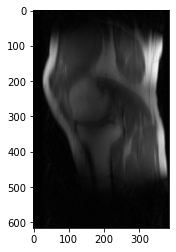

In [53]:
%time images = KSpaceGenerator.transform_to_images(Y)
plt.imshow(np.abs(images[5]), cmap='gray')
plt.show()
%time images_alias = KSpaceGenerator.transform_to_images(X)
plt.imshow(np.abs(images_alias[5]), cmap='gray')
plt.show()